In [91]:
!pip install pytest matplotlib numpy

In [92]:
# === CELL 1: SCENARIO & CONFIGURATION (SMART HUB NIGHT SCAN) ===
"""
Defines the core data structures, configuration, and airspace scenario
for a night-time perimeter scan around a smart logistics hub near Pune.

This cell is intentionally domain-focused: no geometry or deconfliction
logic here, just the "world" the engine operates in.
"""

from dataclasses import dataclass
from typing import List, Dict

import numpy as np  # used later for trajectory generation, imported here once


# --- Core data types ---------------------------------------------------------

@dataclass
class Waypoint:
    """Single 4D waypoint along a drone trajectory."""
    x: float          # meters (local X in hub frame)
    y: float          # meters (local Y in hub frame)
    z: float          # meters AGL (altitude)
    time: float       # seconds from mission start


@dataclass
class DeconflictionConfig:
    """
    Tunable configuration for the strategic clearance engine.

    safety_radius_m:     minimum allowed 3D separation between drones.
    samples_per_segment: how densely to sample between waypoints when
                         constructing trajectories for distance checks.
    """
    safety_radius_m: float = 50.0
    samples_per_segment: int = 80


# Single global config instance used by the rest of the code
CONFIG = DeconflictionConfig()


# --- Primary mission: perimeter scan ----------------------------------------

def define_perimeter_scan_mission() -> Dict:
    """
    Night-time perimeter scan around a smart logistics hub near Pune.

    The drone takes off near the south‑west corner of the warehouse,
    flies a rectangular loop around the roof at low altitude, and
    must finish within a 10‑minute slot before morning traffic ramps up.
    """
    perimeter_alt = 60.0  # low layer, below most transit traffic
    return {
        "mission_id": "night_perimeter_scan_pune_hub_v1",
        "waypoints": [
            # SW -> SE -> NE -> NW (warehouse perimeter)
            Waypoint(0,   0,  perimeter_alt,   0),   # SW
            Waypoint(120, 0,  perimeter_alt,  60),   # SE
            Waypoint(120, 80, perimeter_alt, 180),   # NE
            Waypoint(0,   80, perimeter_alt, 300),   # NW
        ],
        "t_start": 0,
        "t_end": 600,  # 10‑minute clearance window
    }


# --- Other scheduled traffic around the hub ---------------------------------

def define_scheduled_traffic() -> List[Dict]:
    """
    Simulated traffic around the hub:

    - early-slot cargo corridor along south edge (low‑mid altitude)
    - diagonal urban delivery corridor above the hub
    - high‑altitude emergency-response corridor cutting across the site
    """
    return [
        {
            "id": "early_cargo_south_corridor",
            "role": "cargo",
            "waypoints": [
                Waypoint(-50, -30, 80, 120),
                Waypoint(200, -30, 80, 260),
            ],
            "t_start": 120,
            "t_end": 260,
        },
        {
            "id": "urban_diag_delivery",
            "role": "delivery",
            "waypoints": [
                Waypoint(-50, -50, 100, 100),
                Waypoint(200, 200, 100, 400),
            ],
            "t_start": 100,
            "t_end": 400,
        },
        {
            "id": "emergency_overpass_lane",
            "role": "emergency",
            "waypoints": [
                Waypoint(0,   150, 130,  50),
                Waypoint(150, -50, 130, 250),
            ],
            "t_start": 50,
            "t_end": 250,
        },
    ]


print("Scenario: night perimeter scan around smart hub loaded.")
print("Scheduled traffic drones:", len(define_scheduled_traffic()))


Scenario: night perimeter scan around smart hub loaded.
Scheduled traffic drones: 3


In [93]:
# === CELL 2: TRAJECTORY GEOMETRY (3D) ===
"""
Geometry helpers for building 3D trajectories and measuring separation
between drones in shared airspace.
"""

# Short alias so we do not have to reach into CONFIG everywhere.
SAFETY_RADIUS_M = CONFIG.safety_radius_m


def interpolate_trajectory_3d(
    waypoints: List[Waypoint],
    samples_per_segment: int | None = None,
):
    """
    Turn a list of 4D waypoints into a sampled 3D trajectory.

    Assumptions:
    - Motion between waypoints is piecewise linear in x, y, z.
    - Time stamps in the waypoints are monotonically increasing.

    This keeps the model simple on purpose: the assignment is assessing
    strategic deconfliction, not low‑level flight dynamics.
    """
    if samples_per_segment is None:
        samples_per_segment = CONFIG.samples_per_segment

    # Extract time and position arrays
    times = np.array([wp.time for wp in waypoints])
    pts = np.array([[wp.x, wp.y, wp.z] for wp in waypoints])

    # Decide how many samples we want across the whole path
    total_samples = max(len(waypoints) * samples_per_segment, 2)
    t_interp = np.linspace(times[0], times[-1], total_samples)

    # Interpolate each coordinate independently over time
    x = np.interp(t_interp, times, pts[:, 0])
    y = np.interp(t_interp, times, pts[:, 1])
    z = np.interp(t_interp, times, pts[:, 2])

    # Stack x, y, z into a (N, 3) array and return with the time vector
    return np.column_stack([x, y, z]), t_interp


def compute_min_separation(traj1: np.ndarray, traj2: np.ndarray) -> float:
    """
    Compute the minimum 3D separation (in meters) between two trajectories.

    traj1, traj2: arrays of shape (N, 3) and (M, 3) in the same coordinate
                  frame. We compute all pairwise distances and return the
                  smallest one.
    """
    diffs = traj1[:, np.newaxis, :] - traj2[np.newaxis, :, :]
    dists = np.linalg.norm(diffs, axis=2)
    return float(np.min(dists))


# Quick geometry sanity check on the current scenario
mission = define_perimeter_scan_mission()
traffic0 = define_scheduled_traffic()[0]
traj_m, _ = interpolate_trajectory_3d(mission["waypoints"])
traj_t, _ = interpolate_trajectory_3d(traffic0["waypoints"])
print("Example separation to early cargo:",
      f"{compute_min_separation(traj_m, traj_t):.1f} m")


Example separation to early cargo: 36.1 m


In [94]:
# === CELL 3: STRATEGIC CLEARANCE ENGINE ===
"""
Core decision logic for the strategic clearance engine.

Given the perimeter-scan mission and scheduled traffic around the hub,
this module decides whether the mission is SAFE TO FLY, attaches a
qualitative risk level, and produces a human-readable summary.
"""

from typing import Any, Dict


def time_windows_overlap(t1_start: float, t1_end: float,
                         t2_start: float, t2_end: float) -> bool:
    """
    Return True if two mission time windows overlap in time.

    Overlap is defined as any non-empty intersection between intervals
    [t1_start, t1_end] and [t2_start, t2_end].
    """
    return max(t1_start, t2_start) < min(t1_end, t2_end)


def classify_risk_level(worst_sep: float, safety_radius: float) -> str:
    """
    Classify overall mission risk based on worst 3D separation.

    - "high"   : safety radius was violated at least once
    - "medium" : stayed clear but came within 2x safety radius
    - "low"    : comfortably separated from all scheduled traffic
    """
    if worst_sep == float("inf"):
        # No relevant traffic (no time overlap), treat as low risk.
        return "low"
    if worst_sep < safety_radius:
        return "high"
    if worst_sep < 2 * safety_radius:
        return "medium"
    return "low"


def evaluate_mission_clearance(
    mission: Dict[str, Any] | None = None,
    config: DeconflictionConfig = CONFIG,
) -> Dict:
    """
    Evaluate whether the perimeter-scan mission can be flown safely.

    Returns a dictionary with:
    - status: "clear" | "blocked"
    - risk_level: "low" | "medium" | "high"
    - worst_separation_m: float | None
    - conflicts: list of per-flight conflict details
    - mission, config: echoed back for convenience
    """
    if mission is None:
        mission = define_perimeter_scan_mission()

    mission_traj, _ = interpolate_trajectory_3d(mission["waypoints"])
    conflicts: list[Dict[str, Any]] = []
    worst_separation = float("inf")

    for flight in define_scheduled_traffic():
        # Skip flights whose time windows do not overlap with the mission.
        if not time_windows_overlap(
            mission["t_start"], mission["t_end"],
            flight["t_start"], flight["t_end"],
        ):
            continue

        traffic_traj, _ = interpolate_trajectory_3d(flight["waypoints"])
        separation = compute_min_separation(mission_traj, traffic_traj)
        worst_separation = min(worst_separation, separation)

        # Record a conflict only when we actually violate the safety radius.
        if separation < config.safety_radius_m:
            conflicts.append({
                "drone_id": flight["id"],
                "role": flight["role"],
                "min_separation_m": round(separation, 1),
                "overlap_window_s": (
                    max(mission["t_start"], flight["t_start"]),
                    min(mission["t_end"],  flight["t_end"]),
                ),
            })

    status = "clear" if not conflicts else "blocked"
    risk_level = classify_risk_level(worst_separation, config.safety_radius_m)

    return {
        "status": status,
        "risk_level": risk_level,   # extra feature beyond spec
        "worst_separation_m": None if worst_separation == float("inf")
                              else round(worst_separation, 1),
        "conflicts": conflicts,
        "mission": mission,
        "config": config,
    }


def summarize_clearance(result: Dict) -> str:
    """
    Produce a concise, human-readable summary for logs or operator UI.
    """
    if result["status"] == "clear":
        return (
            f"Mission {result['mission']['mission_id']} CLEARED "
            f"with risk level {result['risk_level']} "
            f"(worst separation {result['worst_separation_m']} m)."
        )

    lines = [
        f"Mission {result['mission']['mission_id']} BLOCKED "
        f"(risk level {result['risk_level']}).",
        "Conflicts detected:",
    ]
    for c in result["conflicts"]:
        start, end = c["overlap_window_s"]
        lines.append(
            f"- {c['drone_id']} [{c['role']}] violates safety radius "
            f"({c['min_separation_m']} m) between t={start}s and t={end}s."
        )
    return "\n".join(lines)


# Run once and print summary for the default mission
decision = evaluate_mission_clearance()
print(summarize_clearance(decision))


Mission night_perimeter_scan_pune_hub_v1 BLOCKED (risk level high).
Conflicts detected:
- early_cargo_south_corridor [cargo] violates safety radius (36.1 m) between t=120s and t=260s.
- urban_diag_delivery [delivery] violates safety radius (40.0 m) between t=100s and t=400s.


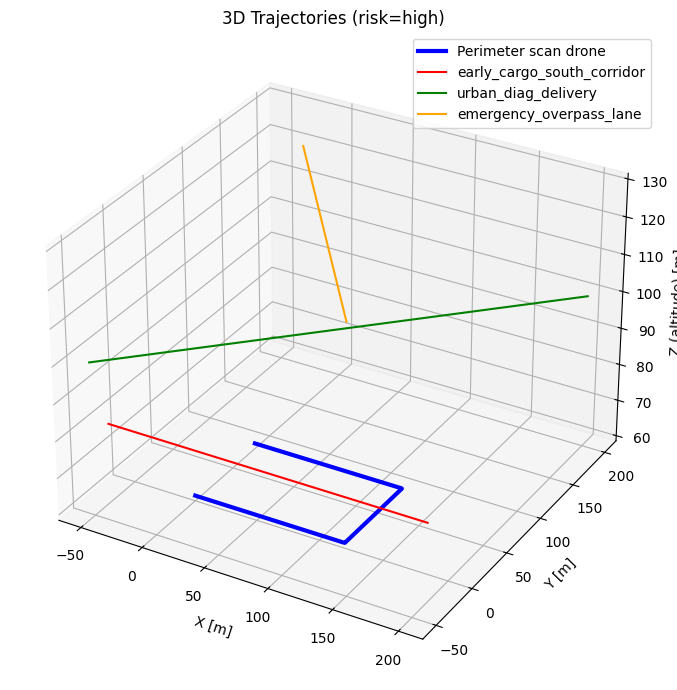

In [95]:
# === CELL 4: 3D TRAJECTORY VISUALIZATION ===
"""
Visualization helpers for inspecting the airspace around the smart hub.

This plot is used in the demo video to show:
- the perimeter-scan mission (our drone)
- the scheduled traffic lanes
- the overall qualitative risk level for the mission
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 – required for 3D projection


def plot_3d_trajectories(result: Dict) -> None:
    """
    Render a 3D view of the mission and all scheduled traffic.

    result: output dictionary from evaluate_mission_clearance.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # --- Primary mission: perimeter scan drone --------------------------------
    mission = result["mission"]
    traj_p, _ = interpolate_trajectory_3d(mission["waypoints"])
    ax.plot(
        traj_p[:, 0], traj_p[:, 1], traj_p[:, 2],
        color="blue", linewidth=3, label="Perimeter scan drone",
    )

    # --- Scheduled traffic around the hub -------------------------------------
    colors = {"cargo": "red", "delivery": "green", "emergency": "orange"}
    for flight in define_scheduled_traffic():
        traj, _ = interpolate_trajectory_3d(flight["waypoints"])
        ax.plot(
            traj[:, 0], traj[:, 1], traj[:, 2],
            color=colors[flight["role"]], label=flight["id"],
        )

    # --- Axes formatting and labels -------------------------------------------
    ax.set_title(f"3D Trajectories (risk={result['risk_level']})")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z (altitude) [m]")
    ax.legend()
    plt.tight_layout()
    plt.show()


# Render once for the current decision
plot_3d_trajectories(decision)


In [96]:
!pip install pytest pytest-sugar
import pytest


In [97]:
# === CELL 5: TEST HARNESS (NOTEBOOK VERSION) ===
"""
Lightweight test harness for the clearance engine.

In the repo, these tests live in tests/test_engine.py and are run by
pytest. Inside this notebook we keep a simple run_all_tests() wrapper
so we can quickly verify behavior after making changes.
"""

import math


def test_conflict_detected():
    """
    Sanity check: with the default scenario, at least one conflict
    must be detected (early cargo lane near the south edge).
    """
    result = evaluate_mission_clearance()
    assert result["status"] == "blocked"
    assert any(
        c["drone_id"] == "early_cargo_south_corridor"
        for c in result["conflicts"]
    )


def test_no_conflict_when_far_apart():
    """
    If we translate the mission 1 km east, it should be clear of all
    scheduled traffic in both space and time.
    """
    mission = define_perimeter_scan_mission()
    for wp in mission["waypoints"]:
        wp.x += 1000  # move 1 km east

    result = evaluate_mission_clearance(mission)
    assert result["status"] == "clear"


def test_3d_distance_uses_altitude():
    """
    Two vertical points with identical x,y but 30 m difference in z
    should have a 3D separation of exactly 30 m.
    """
    w1 = Waypoint(0, 0, 0, 0)
    w2 = Waypoint(0, 0, 30, 10)

    traj1, _ = interpolate_trajectory_3d(
        [w1, Waypoint(0, 0, 0, 10)], samples_per_segment=1
    )
    traj2, _ = interpolate_trajectory_3d(
        [w2, Waypoint(0, 0, 30, 20)], samples_per_segment=1
    )
    d = compute_min_separation(traj1, traj2)
    assert math.isclose(d, 30.0, rel_tol=1e-3)


def test_exact_safety_buffer_is_clear():
    """
    Two straight, parallel segments exactly SAFETY_RADIUS_M apart
    should be treated as clear (no violation).
    """
    a1 = Waypoint(0, 0, 100, 0)
    a2 = Waypoint(100, 0, 100, 10)

    b1 = Waypoint(0, SAFETY_RADIUS_M, 100, 0)
    b2 = Waypoint(100, SAFETY_RADIUS_M, 100, 10)

    traj1, _ = interpolate_trajectory_3d([a1, a2], samples_per_segment=1)
    traj2, _ = interpolate_trajectory_3d([b1, b2], samples_per_segment=1)
    d = compute_min_separation(traj1, traj2)
    assert math.isclose(d, SAFETY_RADIUS_M, rel_tol=1e-3)


def test_no_conflict_when_no_time_overlap():
    """
    Reuse the same spatial path but shift the mission far forward in time.
    With no temporal overlap, the mission should be clear.
    """
    mission = define_perimeter_scan_mission()
    shifted = {
        "mission_id": mission["mission_id"] + "_shifted",
        "waypoints": [],
        "t_start": mission["t_start"] + 10_000,
        "t_end":   mission["t_end"]   + 10_000,
    }

    for wp in mission["waypoints"]:
        shifted["waypoints"].append(
            Waypoint(wp.x, wp.y, wp.z, wp.time + 10_000)
        )

    result = evaluate_mission_clearance(shifted)
    assert result["status"] == "clear"


def run_all_tests() -> None:
    """
    Execute all test_* functions and print a compact status line
    for each. This mirrors a tiny subset of what pytest would do.
    """
    tests = [
        ("conflict_detected", test_conflict_detected),
        ("no_conflict_when_far_apart", test_no_conflict_when_far_apart),
        ("3d_distance_uses_altitude", test_3d_distance_uses_altitude),
        ("exact_safety_buffer_is_clear", test_exact_safety_buffer_is_clear),
        ("no_conflict_when_no_time_overlap", test_no_conflict_when_no_time_overlap),
    ]
    for name, fn in tests:
        try:
            fn()
            print(f"✅ {name} passed")
        except AssertionError as e:
            print(f"❌ {name} FAILED: {e}")


# Run the tests once for this notebook
run_all_tests()


✅ conflict_detected passed
✅ no_conflict_when_far_apart passed
✅ 3d_distance_uses_altitude passed
✅ exact_safety_buffer_is_clear passed
✅ no_conflict_when_no_time_overlap passed
